In [237]:
import numpy as np
import scipy.misc
from PIL import Image
import colorsys
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

## Functions

In [324]:
def gaussian_weights(source, target, sigma):
    return np.exp(-(source - target)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def hue(source, target, amount):
    """Move the hue of source closer to the target, 
    assuming source and target angles between [-pi; pi],
    according to their distance
    """
    
    if amount != 0:
        sigma = np.pi /2.
        x = np.cos(source) + np.cos(target) * gaussian_weights(np.cos(source), np.cos(target), sigma) * sigma * amount
        y = np.sin(source) + np.sin(target) * gaussian_weights(np.sin(source), np.sin(target), sigma) * sigma * amount

        return np.arctan2(y, x)
    
    else :
        return source
    
def saturation(source, amount):
    sigma = 0.5
    if amount != 0.:
        return source + amount * gaussian_weights(source, 1. - source, sigma)
    else:
        return source

def normal2rad(theta):
    """Remap the hue channel to [-pi; pi] radians assuming source is in [0;1]"""
    
    # Rescale [0; 1] to [0; 2 pi]
    theta = theta * 2 * np.pi
    
    # Remap [pi; 2 pi] to [-pi; 0]
    negative = theta > np.pi # Boolean array : put 1 where theta > pi
    theta[negative] = - (2 * np.pi - theta[negative]) 
    
    return theta

def rad2normal(theta):
    """Remap the hue channel to [0; 1] assuming source is in [-pi; pi] radians"""
    
    # Remap [-pi; 0] to [0; 2 pi]
    negative = theta < 0 # Boolean array : put 1 where theta < 0
    theta[negative] = 2 * np.pi + theta[negative]
    
    # Rescale to [0;1]
    theta = theta / (2 * np.pi)
    
    return theta


## Masks

In [239]:
def highlights(pixels, L_max, sigma):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on the max of luminance"""
    
    return gaussian_weights(pixels, L_max, sigma)

def midtones(pixels, sigma):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on 0.5"""
    
    return gaussian_weights(pixels, 0.5, sigma)

def shadows(pixels, L_min, sigma):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on the min of luminance"""
    
    return gaussian_weights(pixels, L_min, sigma)

def luma_masks(pixels, sigma=1/8.):
    """Utility function to build 3 luma masks at once and normalize the weights"""
    
    L_max = np.amax(pixels)
    L_min = np.amin(pixels)
    
    high = highlights(pixels, L_max, 2 * sigma)
    low = shadows(pixels, L_min, 2 * sigma)
    mid = midtones(pixels, sigma) * (1 + 2 * sigma)

    norm =  high + low + mid
    
    return low/norm, mid/norm, high/norm

## Test the functions behavior on the whole range

In [240]:
theta = np.arange(0, 1, 0.001)

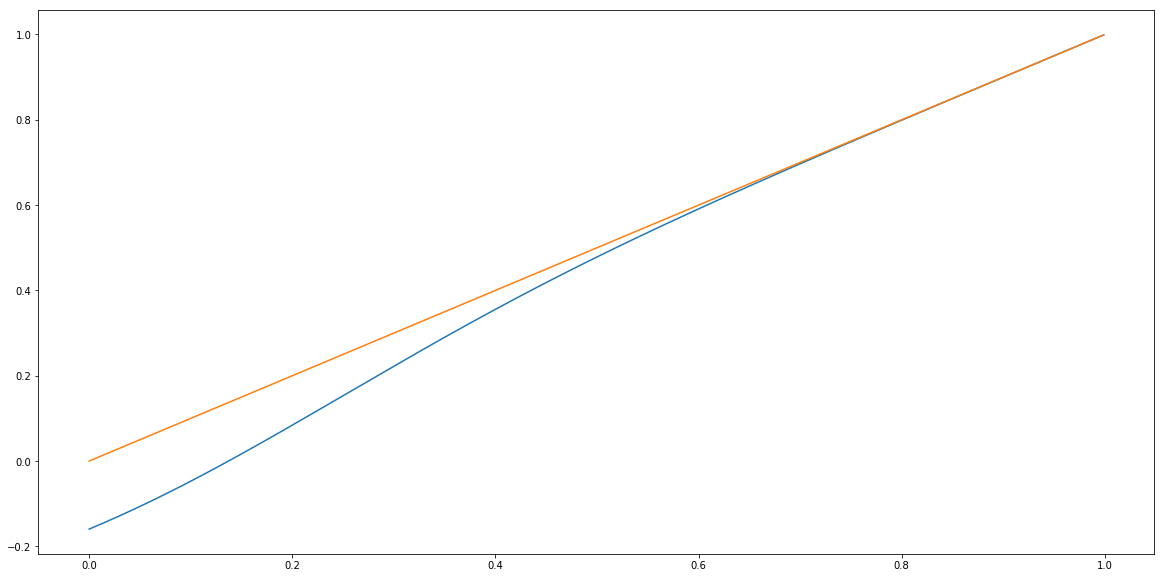

In [323]:
y = saturation(theta, -0.1)
plt.plot(theta, y)
plt.plot(theta, theta)
plt.show()

### Shift colors to red (0°)

This graphs shows how hues from the whole chromatic wheel ([0;1], corresponding to [0°;360°]) are remaped to red (0, 0°). The curve in orange is the original hue repartition (linear). The curve in blue, the target is (0, 0), the complimentary color is (0.5, 0.5).

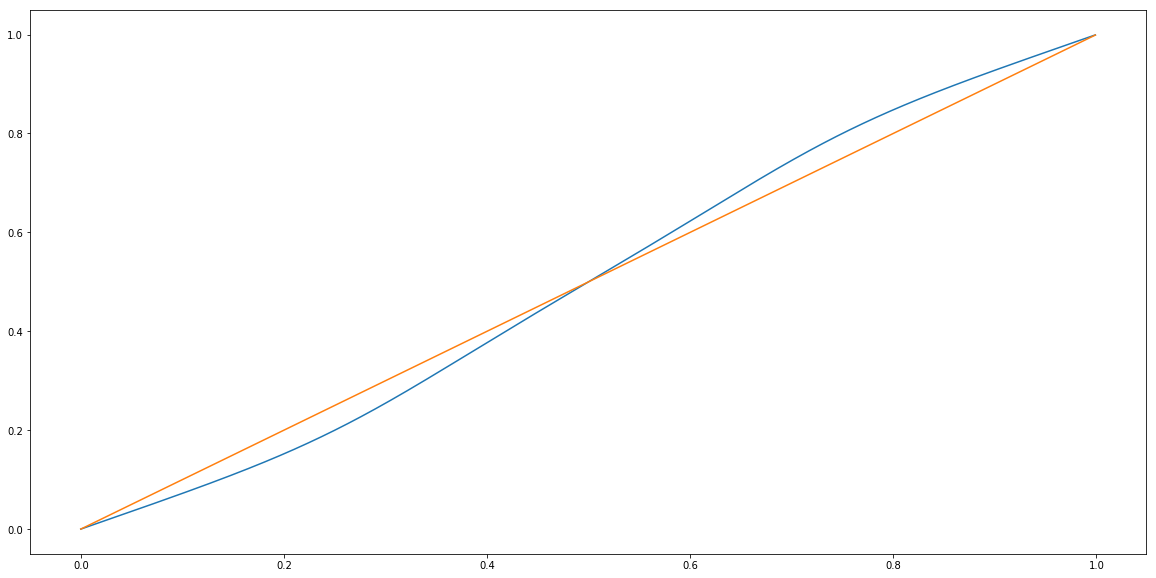

In [280]:
y = rad2normal(hue(normal2rad(theta), 0, 1.))
plt.plot(theta, y)
plt.plot(theta, theta)
plt.show()

### Shift colors to cyan (180°)

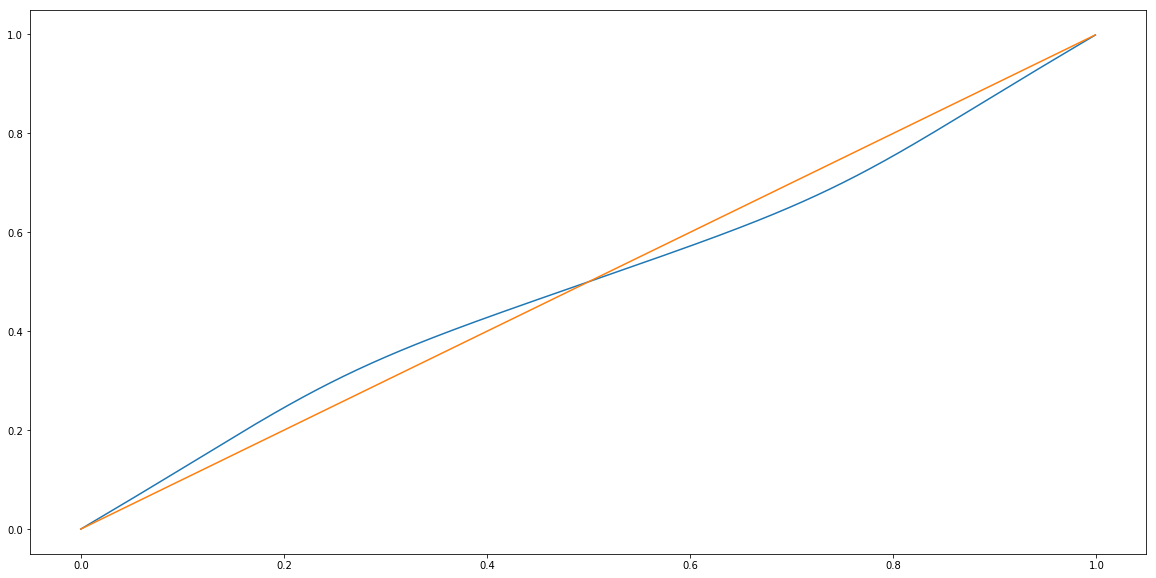

In [281]:
y = rad2normal(hue(normal2rad(theta), np.pi, 1))
plt.plot(theta, y)
plt.plot(theta, theta)
plt.show()

### Shift color to green-ish (90°)

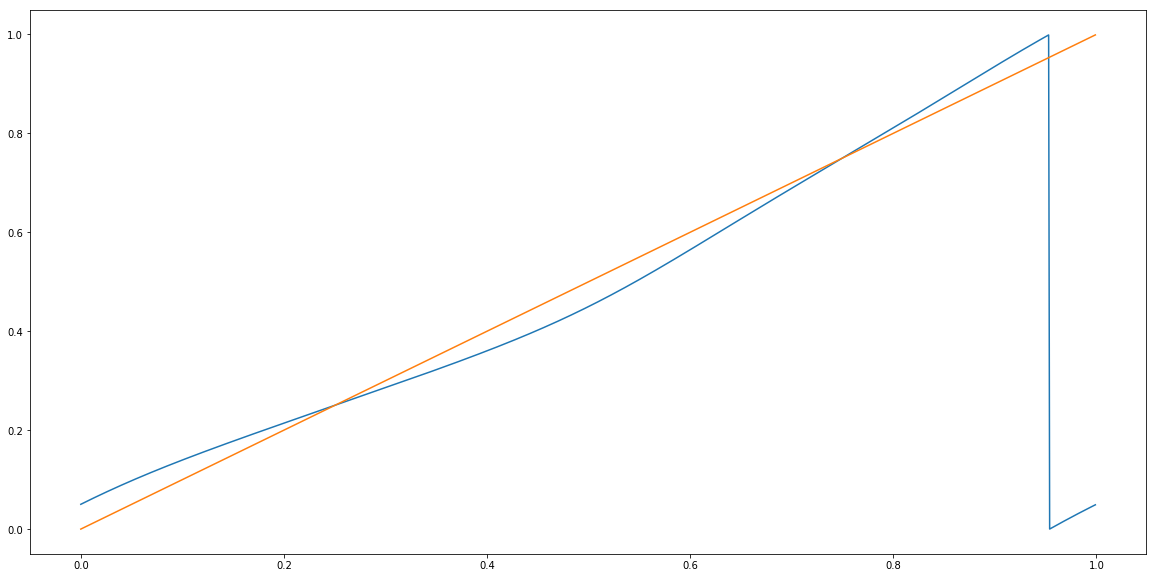

In [282]:
y = rad2normal(hue(normal2rad(theta), np.pi/2, 1))
plt.plot(theta, y)
plt.plot(theta, theta)
plt.show()

### Check the luma masks

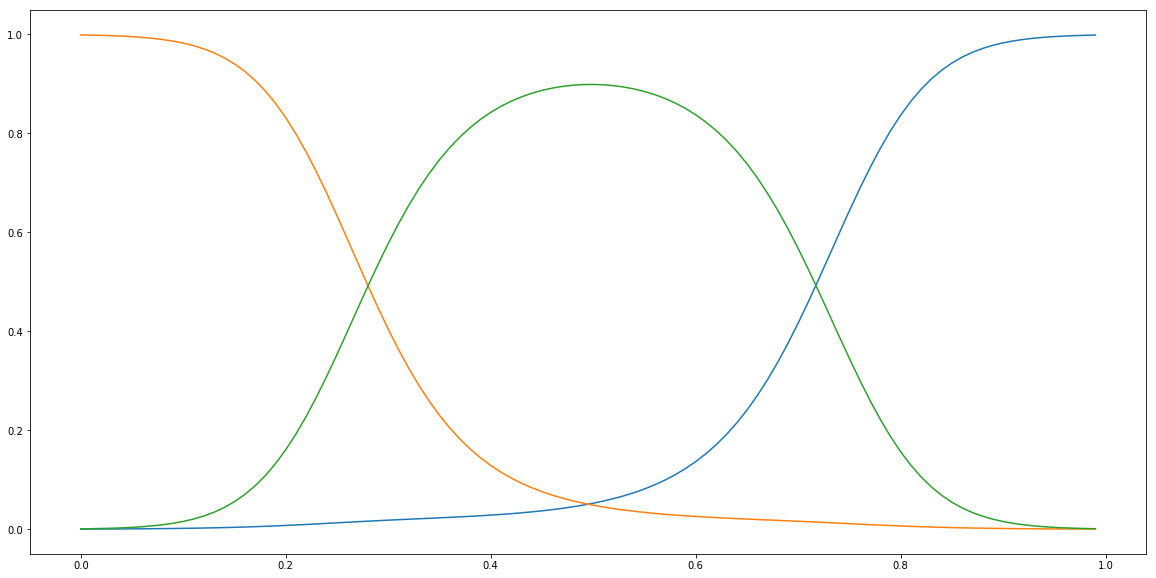

In [283]:
x = np.arange(0, 1, 0.01)

low, mid, high = luma_masks(x)

plt.plot(x, high)
plt.plot(x, low)
plt.plot(x, mid)
plt.show()

## Test the functions on a real image

In [245]:
# Load image
im = Image.open("../img/153412.jpg")
im = scipy.misc.imresize(im, 0.25, interp='lanczos')
im = Image.fromarray(im, 'RGB')

/home/aurelien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [297]:
# Convert RGB image to HSL
r,g,b = im.split()
H = []
S = []
L = []    
for red, green, blue in zip(r.getdata(),g.getdata(),b.getdata()):
    h, s, l = colorsys.rgb_to_hsv(red/255.,green/255.,blue/255.)
    H.append(h)
    S.append(s)
    L.append(l)

# Convert to Numpy arrays
H = np.array(H)
L = np.array(L)
S = np.array(S)

# Convert hue to radians
H = normal2rad(H)

In [298]:
# Build the luminance masks
low, mid, high = luma_masks(L)

In [299]:
# Adjust the main hue
H_bis = hue(H, np.pi/6., 1)

In [300]:
# Adjust hue selectively for luminance zones 
H_bis = hue(H_bis, np.pi/3., 1) * high + hue(H_bis, 4.2, 1) * mid + hue(H_bis, 4.2, 1) * low

In [304]:
# Adjust saturation
S_bis = saturation(S, 0.2) * high + saturation(S, 0.1) * high + saturation(S, 0) * low
#S_bis = np.clip(S_bis, 0., 1.)
S_bis.mean()

0.11760303664286947

In [292]:
# Convert hue back to normal [0;1]
H_bis = rad2normal(H_bis)

# Convert back HSL image to RGB
rout = []
gout = []
bout = []  
for h, s, l in zip(H_bis, S_bis, L):
    rd, gn, bl = colorsys.hsv_to_rgb(h, s, l)
    rout.append(rd * 255)
    gout.append(gn * 255)
    bout.append(bl * 255)

New : push main color to orange (100 %), hightlights to yellow (100 %), midtones and shadows to blue (100 %)


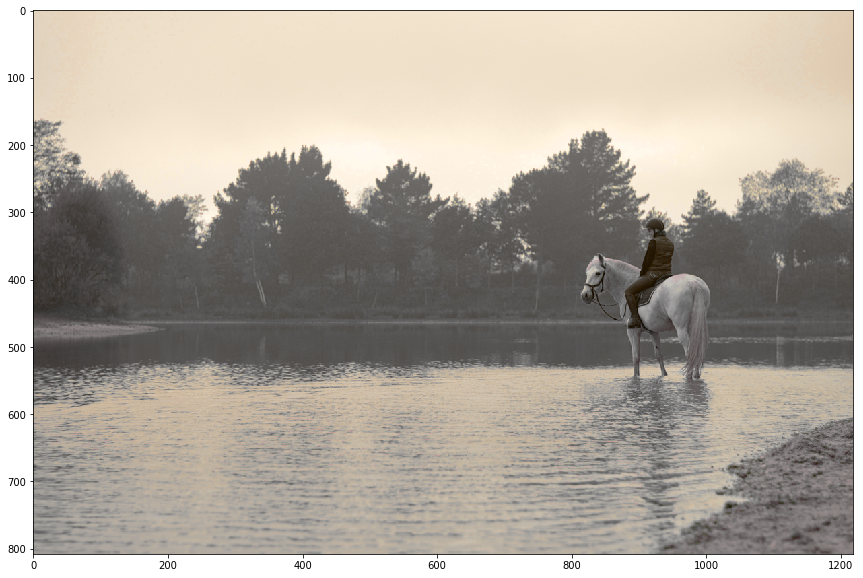

original


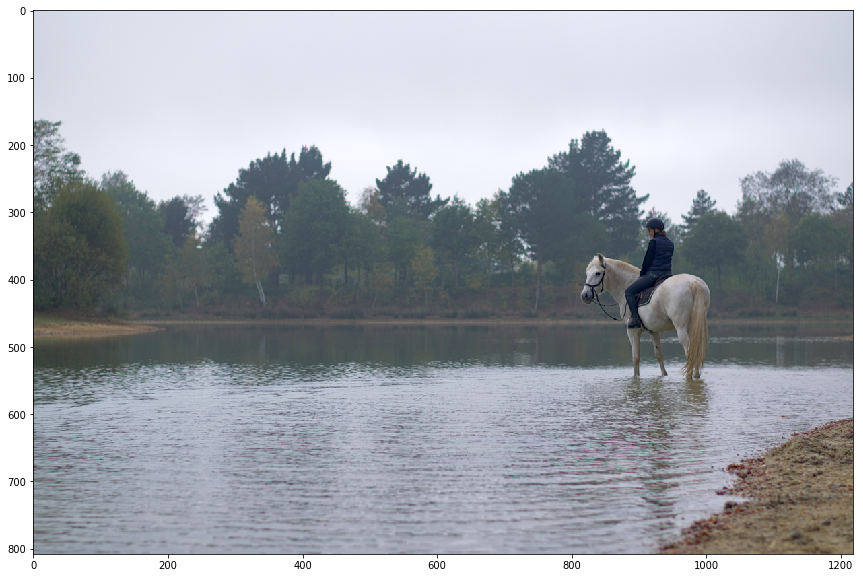

In [293]:
# Save image
r.putdata(rout)
g.putdata(gout)
b.putdata(bout)
newimg = Image.merge('RGB',(r,g,b))
#newimg.save('153412-hue-shift.jpg')
print("New : push main color to orange (100 %), hightlights to yellow (100 %), midtones and shadows to blue (100 %)")
plt.imshow(newimg)
plt.show()
print("original")
plt.imshow(im)
plt.show()